<h1> Cat and Dog Classifier (My first Convolutional Neural Net)</h1>

In this first ConvNet we try to predict whether there is a cat or a dog in a given picture. Therefore we use a dataset provided by kaggle.

The image data will resized (150x150) and split into batches of 16 or 32 elements each. This is done with the ImageDataGenerator class from keras. Afterwards I created a small model with 3 convolutional layers and trained it. The results can be seen below that.

Dataset: https://www.kaggle.com/c/dogs-vs-cats/data

Good Tutorial: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [78]:
import sys
import re
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.python.client import device_lib
KERAS_BACKEND=tf
import keras
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img # Image Preprocessing
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.utils import plot_model

In [3]:
print(K._BACKEND)
#print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

tensorflow
['/job:localhost/replica:0/task:0/device:GPU:0']


In [61]:
''' Constants: '''
BATCH_SIZE = 16
EPOCHS = 50

if sys.platform == 'darwin': # MacOS (My MacBook)
    import os
    TRAIN_DIR = '/Users/basti/Documents/MLDatasets/CatsDogs/dogscats/train'
    TEST_DIR = '/Users/basti/Documents/MLDatasets/CatsDogs/dogscats/valid'
    TEST_KAGGLE_DIR = '/Users/basti/Documents/MLDatasets/CatsDogs/dogscats/test'
    EPOCHS = 10

if sys.platform == 'win32': # Windows (my Home Computer with GPU Nvidia GTX 1060)
    TRAIN_DIR = r'D:\Offline_Programmierung\Machine_Learning\Datasets\dogscats\train'
    TEST_DIR = r'D:\Offline_Programmierung\Machine_Learning\Datasets\dogscats\valid'
    TEST_KAGGLE_DIR = r'D:\Offline_Programmierung\Machine_Learning\Datasets\dogscats\test'
    BATCH_SIZE = 32 # higher batch size to utilize the GPU 

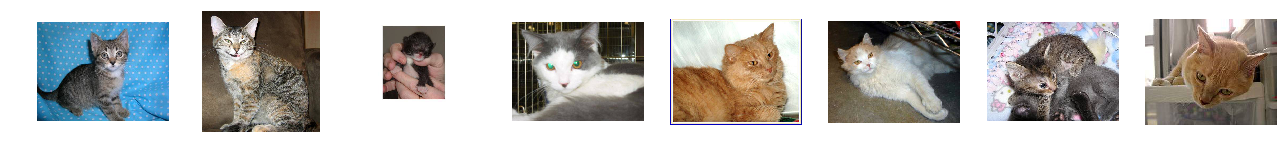

In [6]:
if sys.platform == 'darwin': # MacOS
    filelist = os.listdir(TRAIN_DIR+'/cats/')

    plt.figure(num=None, figsize=(20, 2), dpi=80)
    for i,file in enumerate(filelist[:8]):
        plt.subplot(1,8,i+1)
        img = load_img(TRAIN_DIR+'/cats/'+file)    # this is a PIL image
        plt.imshow(img)
        plt.axis('off')

    # x = img_to_array(img)            # this is a Numpy array with shape (3, 150, 150) # not sure about the 150x150. But doesn't matter.
    # x = x.reshape((1,) + x.shape)    # this is a Numpy array with shape (1, 3, 150, 150) 

In [7]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,               # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=BATCH_SIZE,
        class_mode='binary')     # since we use binary_crossentropy loss, we need binary labels

validation_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


my_test_batch_index: 0
batch images shape: (16, 150, 150, 3)
{'cats': 0, 'dogs': 1}


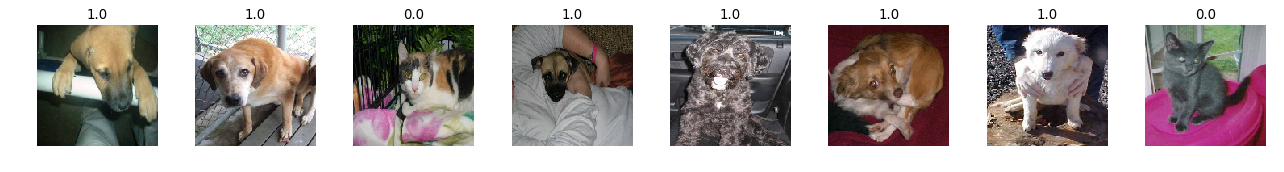

In [9]:
''' Plot 8 images after they've passed the ImageDataGenerator '''

# A Batch is a tuple with two Elements. 0: Data (Images) 1: Labels

my_test_batch_index = validation_generator.batch_index    # get index of current batch
print("my_test_batch_index:", my_test_batch_index)

my_test_batch = validation_generator.next()               # get the current batch (16 elements)

my_test_batch_images = my_test_batch[0]                   # get images [0]
my_test_batch_labels = my_test_batch[1]                   # get labels [1]
print("batch images shape:",my_test_batch_images.shape)   # print batch shape
#print("labels:",my_test_batch_labels)                    # print labels
print(validation_generator.class_indices)

plt.figure(num=None, figsize=(20, 2), dpi=80)
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(my_test_batch_images[i])
    plt.title( my_test_batch_labels[i])
    plt.axis('off')

In [10]:
''' 3 Convolutional Layers '''

# 32:     filters: The dimensionality of the output space (i.e. the number of output filters in the convolution).
# (3, 3): kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3))) # picture x,y,dim
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

On top of it we stick two fully-connected layers. We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification. To go with it we will also use the binary_crossentropy loss to train our model.

In [11]:
model.add(Flatten())                # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))                 # output neuron (1 because of binary classification)
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
# NOTE: Metrics are not used for trainnig the model. So, only the loss function determines the direction of the weights.

In [48]:
model.load_weights('myWeights.h5')

In [47]:
model.load_weights('myWeights.h5')                          # just to be save: load my old pre trained weights
t0 = time.time()
training_history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=800 // BATCH_SIZE)
model.save_weights('myWeights.h5')                          # always save weights after training
np.save('training_history.npy', training_history.history)   # save training_history
print("Running time:",time.time()-t0,"s")

Epoch 1/10
125/125 [==============================] - 98s 787ms/step - loss: 0.4409 - acc: 0.8115 - val_loss: 0.4382 - val_acc: 0.8100
Epoch 2/10
125/125 [==============================] - 90s 723ms/step - loss: 0.4290 - acc: 0.8130 - val_loss: 0.6287 - val_acc: 0.7812
Epoch 3/10
125/125 [==============================] - 87s 696ms/step - loss: 0.4320 - acc: 0.8135 - val_loss: 0.4213 - val_acc: 0.8187
Epoch 4/10
125/125 [==============================] - 96s 764ms/step - loss: 0.4616 - acc: 0.8010 - val_loss: 0.4041 - val_acc: 0.8313
Epoch 5/10
125/125 [==============================] - 97s 775ms/step - loss: 0.4527 - acc: 0.8075 - val_loss: 0.4236 - val_acc: 0.8163
Epoch 6/10
125/125 [==============================] - 96s 768ms/step - loss: 0.4438 - acc: 0.8060 - val_loss: 0.4817 - val_acc: 0.8125
Epoch 7/10
125/125 [==============================] - 98s 782ms/step - loss: 0.4430 - acc: 0.8180 - val_loss: 0.4743 - val_acc: 0.7837
Epoch 8/10
125/125 [==============================] - 9

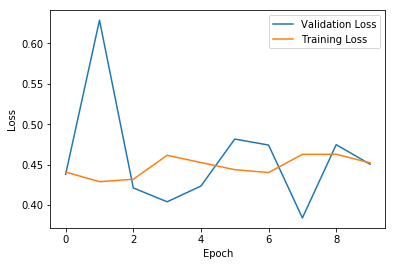

In [49]:
''' Plot Loss over time: '''
training_history = np.load('training_history.npy') # load history of last training
val_loss_hist = training_history[()]['val_loss']   # val_loss is loss of the validation dataset.
loss_hist     = training_history[()]['loss']       # training loss

plt.plot(range(len(val_loss_hist)), val_loss_hist,label="Validation Loss")
plt.plot(range(len(loss_hist)), loss_hist,label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
''' Plot the Model and save it as png: '''

if sys.platform == 'darwin': # MacOS
    # get the next file index:
    i = 0
    while os.path.exists("model_plots/model%s.png" % i):
        i += 1
    # save model as png:
    plot_model(model, to_file='model_plots/model%s.png' % i)

In [24]:
# my_test_image = np.expand_dims(my_test_images[0], axis=0) # add a dimension so this works as an input
# print(validation_generator.class_indices)
# print(validation_generator.classes[950:1050])

# prediction for a test batch from the validation set.
print("One Batch:",model.test_on_batch(my_test_batch[0], my_test_batch[1]))
print(model.metrics_names)

# prediction for full validation set.
print("Complete Validation set:",model.evaluate_generator(validation_generator))
print(model.metrics_names)

One Batch: [0.16888578, 0.9375]
['loss', 'acc']
Complete Validation set: [0.399961198925972, 0.8305]
['loss', 'acc']


In [50]:
validation_imgs_predicted = model.predict_generator(validation_generator)


In [87]:
# diff = np.round(validation_imgs_predicted,0).reshape(-1) - validation_generator.classes
# print("Accuracy by hand: ",1 - np.count_nonzero(diff) / validation_generator.classes.shape[0])
# this dosent work because the ordering of the predictions and the classes is different i think (shuffle=True)

<h2> Predict test set for submission to kaggle </h2>

In [62]:
test_kaggle_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        TEST_KAGGLE_DIR,
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode=None, 
        shuffle=False)
# Do not shuffle here, this dataset will only be predicted so there is no need to shuffle. 
# I also need the order to generate my submission
# class_mode=None <- "no labels are returned (the generator will only yield batches of image data, 
# which is useful to use with  model.predict_generator(),  model.evaluate_generator(), etc.)"

Found 12500 images belonging to 1 classes.


In [66]:
test_kaggle_predicted = model.predict_generator(test_kaggle_generator)


In [112]:
''' get image Id's '''
filenames = test_kaggle_generator.filenames
regex = re.compile(r'\d+')

fileIds = np.array([int(regex.findall(filenames[i])[1]) for i in range(len(filenames))]).astype(np.int32)
print(fileIds.shape)

(12500,)


In [113]:
submission_array = np.column_stack((fileIds, test_kaggle_predicted))
submission = pd.DataFrame(submission_array, columns=['id','label'])  # 1st row as the column names
submission[['id']] = submission[['id']].astype(np.int32)             # id's to int
print(submission[0:15])

       id     label
0       1  0.977971
1      10  0.343490
2     100  0.944026
3    1000  0.999951
4   10000  0.971307
5   10001  0.087345
6   10002  0.346339
7   10003  0.997254
8   10004  0.658946
9   10005  0.120162
10  10006  0.064522
11  10007  0.045748
12  10008  0.031787
13  10009  0.353869
14   1001  0.847053


In [119]:
submission.to_csv('submission1.csv', index=False) 

<h2>Results:</h2>

<h3>Original Kaggle Challenge "Dogs vs. Cats" from 2014:</h3>

My validation Accuracy = 0.8305

If the test accuracy would be the same I would have scored rank 87 from 215 participants -> top 40%

Sadly, you cannot score on this challenge anymore.

<h3>Kaggle challenge "Dogs vs. Cats Redux: Kernels Edition" 2017:</h3>

At this challenge a late submission was possible.

I got 0.43118 test loss (Accuracy is not provided)

This got me to rank 907 out of 1314 -> top 70% (only)


The Results for this small network are already ok. For now, I'm not going to optimize this. I rather focus on a more interesting computer vision Kaggle challenge, maybe the Galaxy Zoo. 